In [ ]:
import pymongo as pm #import MongoClient only
import ast
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import array
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
client = pm.MongoClient('bigdatadb.polito.it',
ssl=True,
authSource = 'carsharing',
username = 'ictts',
password ='Ict4SM22!',
tlsAllowInvalidCertificates=True)
db = client['carsharing'] #Choose the DB to use
Bookings_col = db['ictts_PermanentBookings'] # Collection for Car2go to use
Enjoy_Bookings_col = db['ictts_enjoy_PermanentBookings'] # Collection for Car2go to use

with open('data/IMQ/Zone/TorinoZonesArray.geojson') as file:
    lines = file.readlines()
    
zones = [ast.literal_eval(line)[0] for line in lines]

In [ ]:
zones

In [ ]:
Bookings_col.find_one()

In [ ]:
#Task 1: checking if data is already filtered
booking_duration = []
for doc in Bookings_col.find({"city": "Torino"}):
    booking_duration.append(doc["final_time"]- doc["init_time"])
    
booking_durations_np = np.array(booking_duration)/60
sorted_durations = np.sort(booking_durations_np)

cumulative_probabilities = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)

plt.figure(figsize=(8, 5))
plt.plot(sorted_durations, cumulative_probabilities, label="Torino")


plt.xlabel("Booking Duration (minutes)")
plt.ylabel("Cumulative Probability")
plt.title("Empirical CDF of Booking Durations")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Task 1: OD matrix of all bookings
od_matrix = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$match": { 
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix[i, j] = 0



In [ ]:
#od_amtrix enjoy
od_matrix_e = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$match": { 
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Enjoy_Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_e[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_e[i, j] = 0



In [ ]:
tot_sum = np.sum(od_matrix_e)
od_matrix_norm_e = od_matrix_e / tot_sum

plt.figure()
sns.heatmap(od_matrix_norm_e, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Non Filtered Heat Map Enjoy")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [ ]:
#Task 1: Heat map plot
tot_sum = np.sum(od_matrix)
od_matrix_norm = od_matrix / tot_sum

plt.figure()
sns.heatmap(od_matrix_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Non Filtered Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()


In [ ]:
#Task 1a: filtering data by weekdays
od_matrix_weekdays = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    #"hour": { "$hour": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_weekdays[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_weekdays[i, j] = 0

In [ ]:
tot_sum = np.sum(od_matrix_weekdays)
od_matrix_weekdays_norm = od_matrix_weekdays / tot_sum

plt.figure()
sns.heatmap(od_matrix_weekdays_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Weekdays Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [ ]:
#Task 1a: filtering data by weekends
od_matrix_weekends = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    #"hour": { "$hour": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$in": [1, 7]},
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_weekends[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_weekends[i, j] = 0

In [ ]:
tot_sum = np.sum(od_matrix_weekends)
od_matrix_weekends_norm = od_matrix_weekends / tot_sum

plt.figure()
sns.heatmap(od_matrix_weekends_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Weekends Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [ ]:
pipeline = [
    {
        "$group": {
            "_id": None,
            "minDate": { "$min": "$init_date" }, 
            "maxDate": { "$max": "$init_date" }   
        }
    }
]

result = list(Enjoy_Bookings_col.aggregate(pipeline))

print("Start Date:", result[0]['minDate'])
print("End Date:", result[0]['maxDate'])


In [ ]:
#Task 1b: filter for just a week of data (week 36 of 2017) Start: Monday, September 4th, 2017
od_matrix_week36 = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 36 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week36[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week36[i, j] = 0

In [ ]:
tot_sum = np.sum(od_matrix_week36)
od_matrix_week36_norm = od_matrix_week36 / tot_sum

plt.figure()
sns.heatmap(od_matrix_week36_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 36 of 2017 Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [ ]:
#Task 1b: filter for just a week of data (week 39 of 2017) Start: Monday, September 25, 2017
od_matrix_week39 = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 39 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week39[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week39[i, j] = 0

In [ ]:
tot_sum = np.sum(od_matrix_week39)
od_matrix_week39_norm = od_matrix_week39 / tot_sum

plt.figure()
sns.heatmap(od_matrix_week39_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 39 of 2017 Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [ ]:
#Task 1b: filter for just a week of data (week 39 of 2017) Start: Monday, September 25, 2017
od_matrix_week39_enjoy = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 39 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Enjoy_Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week39_enjoy[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week39_enjoy[i, j] = 0

In [ ]:
tot_sum = np.sum(od_matrix_week39_enjoy)
od_matrix_week39_enjoy_norm = od_matrix_week39_enjoy / tot_sum

plt.figure()
sns.heatmap(od_matrix_week39_enjoy_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 39 of 2017 Heat Map Enjoy")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [ ]:
rand_matrix_A = np.random.rand(23, 23)
rand_matrix_A = rand_matrix_A / np.sum(rand_matrix_A)

rand_matrix_B = np.random.rand(23, 23)
rand_matrix_B = rand_matrix_B / np.sum(rand_matrix_B)

In [ ]:
def simple_distance(matrix1, matrix2):
    return np.sum(np.abs(matrix1 - matrix2))

d1_rand = simple_distance(rand_matrix_A, rand_matrix_B)
print(f"Absolute distance between random matrixes: {d1_rand}")
d1_weeks = simple_distance(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Absolute distance between week 36 and 39: {d1_weeks}")
d1_platfrom = simple_distance(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Absolute distance between Car2go and Enjoy: {d1_platfrom}")

In [ ]:
def euclidean_distance(matrix1, matrix2):
    return np.sqrt(np.sum((matrix1 - matrix2)**2))

d2_rand = euclidean_distance(rand_matrix_A, rand_matrix_B)
print(f"Euclidean distance between random matrixes: {d2_rand}")
d2_weeks = euclidean_distance(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Euclidean distance between week 36 and 39: {d2_weeks}")
d2_platfrom = euclidean_distance(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Euclidean distance between Car2go and Enjoy: {d2_platfrom}")

In [ ]:
def max_absolute_difference(A, B):
    absolute_diff = np.abs(A - B)
    return np.max(absolute_diff)

dMax_rand = max_absolute_difference(rand_matrix_A, rand_matrix_B)
print(f"Max absolute difference between random matrixes: {dMax_rand}")
dMax_weeks = max_absolute_difference(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max absolute difference between week 36 and 39: {dMax_weeks}")
dMax_platfrom = max_absolute_difference(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max absolute difference between Car2go and Enjoy: {dMax_platfrom}")

In [ ]:
def compute_dm(A, B):
    M = A - B
    n = M.shape[0]  # Size of the matrix
    x = np.random.rand(n)  # Random vector
    x /= np.linalg.norm(x)  # Normalize it to have ||x|| = 1
    for _ in range(100):
        x = M.T @ (M @ x)  # Multiply by M.T @ M
        x /= np.linalg.norm(x)  # Normalize to ensure ||x|| = 1
    max_norm = np.linalg.norm(M @ x)
    return max_norm

dNorm_rand = compute_dm(rand_matrix_A, rand_matrix_B)
print(f"Max norm of the difference between random matrixes: {dNorm_rand}")
dNorm_weeks = compute_dm(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max norm of the difference between week 36 and 39: {dNorm_weeks}")
dNorm_platfrom = compute_dm(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max norm of the difference between Car2go and Enjoy: {dNorm_platfrom}")

In [ ]:

def compute_dm2(A, B, iterations=100, tol=1e-9):
    # Step 1: Compute the difference matrix M = A - B
    M = A - B
    n = M.shape[0]  # Number of rows/columns (assuming square matrix)
    
    # Step 2: Start with a random vector x
    x = np.random.rand(n)
    x /= np.linalg.norm(x)  # Normalize x to have ||x|| = 1
    
    # Step 3: Perform power iteration
    prev_norm = 0
    for _ in range(iterations):
        # Multiply M by the current vector x
        x = M @ x
        
        # Compute the 2-norm of the resulting vector
        current_norm = np.linalg.norm(x)
        
        # Normalize x for the next iteration
        x /= current_norm
        
        # Check for convergence
        if abs(current_norm - prev_norm) < tol:
            break
        prev_norm = current_norm
    
    return current_norm

dNorm_rand2 = compute_dm2(rand_matrix_A, rand_matrix_B)
print(f"Max norm of the difference between random matrixes: {dNorm_rand2}")
dNorm_weeks2 = compute_dm2(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max norm of the difference between week 36 and 39: {dNorm_weeks2}")
dNorm_platfrom2 = compute_dm2(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max norm of the difference between Car2go and Enjoy: {dNorm_platfrom2}")

In [ ]:
#question 3


unipol_info = pd.read_csv('./data/Unipoldata/Info_TO.csv')
unipol_trips = pd.read_csv('./data/Unipoldata/Trips_OD_TO.csv')
imq_data = pd.read_csv('./data/IMQ/IMQData_Torino.csv')

unipol_data = pd.merge(unipol_trips, unipol_info, on='id_veicolo')

print("UnipolTech Data:")
print(unipol_data.head())
print("IMQ Data:")
print(imq_data.head())

In [ ]:
from shapely.geometry import Point, Polygon, mapping
import json


with open('./data/IMQ/Zone/TorinoZonescol.geojson') as file:
    data = json.load(file)

zones = []
for feature in data['features']:
    coordinates = feature['geometry']['coordinates']
    if feature['geometry']['type'] == 'Polygon':
        zones.append(Polygon(coordinates[0]))
    elif feature['geometry']['type'] == 'MultiPolygon':
        for polygon in coordinates:
            zones.append(Polygon(polygon[0]))


zone_gdf = gpd.GeoDataFrame(geometry=zones)


def find_zone(lat, lon):
    point = Point(lon, lat)
    for i, zone in enumerate(zones):
        if zone.contains(point):
            return i
    return -1

unipol_data['ORI_ZONE'] = unipol_data.apply(lambda row: find_zone(row['lat_start'], row['lon_start']), axis=1)
unipol_data['DST_ZONE'] = unipol_data.apply(lambda row: find_zone(row['lat_stop'], row['lon_stop']), axis=1)

unipol_data = unipol_data[(unipol_data['ORI_ZONE'] != -1) & (unipol_data['DST_ZONE'] != -1)]

imq_data['ORI_ZONE'] = imq_data['ORI_ZONE'].str.replace('Q', '').astype(int)
imq_data['DST_ZONE'] = imq_data['DST_ZONE'].str.replace('Q', '').astype(int)

imq_data = imq_data[(imq_data['ORI_ZONE'] != -1) & (imq_data['DST_ZONE'] != -1)]

In [ ]:
max_zone_index = 23
od_matrix_unipol = np.zeros((max_zone_index  , max_zone_index ), dtype=int)
od_matrix_imq = np.zeros((max_zone_index , max_zone_index ), dtype=int)

for _, row in unipol_data.iterrows():
    if 1 <= row['ORI_ZONE'] <= max_zone_index and 1 <= row['DST_ZONE'] <= max_zone_index:
        od_matrix_unipol[row['ORI_ZONE'] -1, row['DST_ZONE']-1 ] += 1

# Compute the OD matrix for IMQ
for _, row in imq_data.iterrows():
    if 1 <= row['ORI_ZONE'] <= max_zone_index and 1 <= row['DST_ZONE'] <= max_zone_index:
        od_matrix_imq[row['ORI_ZONE']-1 , row['DST_ZONE'] -1] += 1

od_matrix_unipol_normalized = od_matrix_unipol / od_matrix_unipol.sum()
od_matrix_imq_normalized = od_matrix_imq / od_matrix_imq.sum()

od_matrix_unipol_flat = od_matrix_unipol_normalized.flatten()
od_matrix_imq_flat = od_matrix_imq_normalized.flatten()

distance = compute_dm2(od_matrix_unipol_normalized, od_matrix_imq_normalized)
print(f"Distance between normalized UnipolTech and IMQ OD matrices: {distance}")


plt.figure(figsize=(10, 8))
sns.heatmap(od_matrix_unipol_normalized, annot=True, fmt=".2f", cmap="viridis",xticklabels=range(1, 24), yticklabels=range(1, 24))
plt.title("Normalized OD Matrix UnipolTech")
plt.xlabel("Destination Zone")
plt.ylabel("Origin Zone")

plt.figure(figsize=(10, 8))
sns.heatmap(od_matrix_imq_normalized, annot=True, fmt=".2f", cmap="viridis",xticklabels=range(1, 24), yticklabels=range(1, 24))
plt.title("Normalized OD Matrix IMQ")
plt.xlabel("Destination Zone")
plt.ylabel("Origin Zone")
plt.show()

In [ ]:
#3a
unipol_groups = unipol_data.groupby(['genere', 'eta_approx', 'commerciale'])

imq_groups = imq_data.groupby(['GENDER', 'AGE'])

max_zone_index = 23
def compute_od_matrix(group, max_zone_index):
    od_matrix = np.zeros((max_zone_index , max_zone_index ), dtype=int)
    for _, row in group.iterrows():
        if row['ORI_ZONE'] <= max_zone_index and row['DST_ZONE'] <= max_zone_index:
            od_matrix[row['ORI_ZONE']-1, row['DST_ZONE']-1] += 1
    return od_matrix

unipol_od_matrices = {name: compute_od_matrix(group, max_zone_index) for name, group in unipol_groups}

imq_od_matrices = {name: compute_od_matrix(group, max_zone_index) for name, group in imq_groups}

def normalize_od_matrix(od_matrix):
    return od_matrix / od_matrix.sum()

unipol_od_matrices_normalized = {name: normalize_od_matrix(matrix) for name, matrix in unipol_od_matrices.items()}

imq_od_matrices_normalized = {name: normalize_od_matrix(matrix) for name, matrix in imq_od_matrices.items()}




similarities = {}
for unipol_name, unipol_matrix in unipol_od_matrices_normalized.items():
    for imq_name, imq_matrix in imq_od_matrices_normalized.items():
        similarity = compute_dm2(unipol_matrix, imq_matrix)
        similarities[(unipol_name, imq_name)] = similarity

for (unipol_name, imq_name), similarity in similarities.items():
    unipol_gender, unipol_age, unipol_commercial = unipol_name
    imq_gen, imq_age = imq_name
    print(f"Similarity between UnipolTech group (Gender: {unipol_gender}, Age: {unipol_age}, Commercial: {unipol_commercial}) "
          f"and IMQ group (Gender: {imq_gen}, age: {imq_age}): {similarity}")

In [ ]:
unipol_od_matrices_normalized = {
    (gender, int(age), commercial): matrix
    for (gender, age, commercial), matrix in unipol_od_matrices_normalized.items()
}

imq_od_matrices_normalized = {
    (int(gen), int(age)): matrix
    for (gen, age), matrix in imq_od_matrices_normalized.items()
}


selected_unipol_group = ('F', 47, 'N')  #gender, age , commercial
selected_imq_group = (1,4)  # gender - age

if selected_unipol_group not in unipol_od_matrices_normalized:
    print(f"UnipolTech group {selected_unipol_group} does not exist.")
else:
    print(f"Selected UnipolTech Group: {selected_unipol_group}")

if selected_imq_group not in imq_od_matrices_normalized:
    print(f"IMQ group {selected_imq_group} does not exist.")
else:
    print(f"Selected IMQ Group: {selected_imq_group}")

if selected_unipol_group in unipol_od_matrices_normalized:
    plt.figure(figsize=(10, 8))
    sns.heatmap(unipol_od_matrices_normalized[selected_unipol_group], annot=True, fmt=".2f", cmap="viridis", xticklabels=range(1, 24), yticklabels=range(1, 24))
    plt.title(f"Normalized OD Matrix UnipolTech Group {selected_unipol_group}")
    plt.xlabel("Destination Zone")
    plt.ylabel("Origin Zone")

if selected_imq_group in imq_od_matrices_normalized:
    plt.figure(figsize=(10, 8))
    sns.heatmap(imq_od_matrices_normalized[selected_imq_group], annot=True, fmt=".2f", cmap="viridis", xticklabels=range(1, 24), yticklabels=range(1, 24))
    plt.title(f"Normalized OD Matrix IMQ Group {selected_imq_group}")
    plt.xlabel("Destination Zone")
    plt.ylabel("Origin Zone")

plt.show()

In [ ]:
gender_differences = {}
all_differences = {}
max_difference_age_groups = {}

for gender in imq_data['GENDER'].unique():
    age_groups = [key for key in imq_od_matrices_normalized.keys() if key[0] == gender]
    differences = []
    age_group_pairs = []
    for i in range(len(age_groups)):
        for j in range(i + 1, len(age_groups)):
            age_group1 = age_groups[i]
            age_group2 = age_groups[j]
            similarity = compute_dm2(imq_od_matrices_normalized[age_group1], imq_od_matrices_normalized[age_group2])
            differences.append(similarity)
            age_group_pairs.append((age_group1[1], age_group2[1]))
    all_differences[gender] = list(zip(age_group_pairs, differences))
    max_difference_index = np.argmax(differences)
    gender_differences[gender] = differences[max_difference_index]
    max_difference_age_groups[gender] = age_group_pairs[max_difference_index]


for gender, diffs in all_differences.items():
    print(f"Differences for gender {gender}:")
    for (age_group1, age_group2), difference in diffs:
        print(f"  Between ages {age_group1} and {age_group2}: {difference}")


for gender, difference in gender_differences.items():
    age_group1, age_group2 = max_difference_age_groups[gender]
    print(f"Maximum difference in behavior across age groups for gender {gender}: {difference} (between ages {age_group1} and {age_group2})")

max_difference_gender = max(gender_differences, key=gender_differences.get)
print(f"Gender with greater differences in behavior across age groups: {max_difference_gender}")

In [ ]:
car2go_data = pd.DataFrame(list(Bookings_col.find()))
enjoy_data = pd.DataFrame(list(Enjoy_Bookings_col.find()))

with open('./data/IMQ/Zone/TorinoZonescol.geojson') as file:
    data = json.load(file)

zones = []
for feature in data['features']:
    coordinates = feature['geometry']['coordinates']
    if feature['geometry']['type'] == 'Polygon':
        zones.append(Polygon(coordinates[0]))
    elif feature['geometry']['type'] == 'MultiPolygon':
        for polygon in coordinates:
            zones.append(Polygon(polygon[0]))


zone_gdf = gpd.GeoDataFrame(geometry=zones)


def find_zone(lat, lon):
    point = Point(lon, lat)
    for i, zone in enumerate(zones):
        if zone.contains(point):
            return i
    return -1

def compute_od_matrix(group, max_zone_index):
    od_matrix = np.zeros((max_zone_index + 1, max_zone_index + 1), dtype=int)
    for _, row in group.iterrows():
        if row['origin'] <= max_zone_index and row['dest'] <= max_zone_index:
            od_matrix[row['origin'], row['dest']] += 1
    return od_matrix



car2go_od_matrix_normalized = normalize_od_matrix(od_matrix)
enjoy_od_matrix_normalized = normalize_od_matrix(od_matrix_e)

similarities = {}
for name, matrix in imq_od_matrices_normalized.items():
    car2go_similarity = compute_dm2(matrix, car2go_od_matrix_normalized)
    enjoy_similarity = compute_dm2(matrix, enjoy_od_matrix_normalized)
    similarities[name] = {'Car2GO': car2go_similarity, 'Enjoy': enjoy_similarity}

for name, sim in similarities.items():
    print(f"Similarity for group {name}: Car2GO = {sim['Car2GO']}, Enjoy = {sim['Enjoy']}")

max_car2go_similarity = min(similarities.items(), key=lambda x: x[1]['Car2GO'])
max_enjoy_similarity = min(similarities.items(), key=lambda x: x[1]['Enjoy'])

print(f"Maximum similarity for Car2GO: Group {max_car2go_similarity[0]} with similarity {max_car2go_similarity[1]['Car2GO']}")
print(f"Maximum similarity for Enjoy: Group {max_enjoy_similarity[0]} with similarity {max_enjoy_similarity[1]['Enjoy']}")

## Task 4
The idea is to use the KDE and estimate the 20 points of the city of Turin with highest densityof trips as hospot and then use Voronoi clustering to create zones around them

In [2]:
import pymongo as pm
import ast
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from scipy.stats import gaussian_kde
from scipy.spatial import Voronoi
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# MongoDB Connection
client = pm.MongoClient(
    'bigdatadb.polito.it',
    ssl=True,
    authSource='carsharing',
    username='ictts',
    password='Ict4SM22!',
    tlsAllowInvalidCertificates=True
)

# Database and Collections
db = client['carsharing']
car2go_col = db['ictts_PermanentBookings']
enjoy_col = db['ictts_enjoy_PermanentBookings']

# Load CarSharing Trips
def load_trips(collection):
    return [
        {"latitude": doc["init_loc"]["coordinates"][1], "longitude": doc["init_loc"]["coordinates"][0]}
        for doc in collection.find({"city": "Torino"}) if 'init_time' in doc and 'final_time' in doc
    ]

car2go_trips = load_trips(car2go_col)
enjoy_trips = load_trips(enjoy_col)

# Combine and Convert to GeoDataFrame
trips_data = pd.DataFrame(car2go_trips + enjoy_trips)
trips_gdf = gpd.GeoDataFrame(
    trips_data, geometry=gpd.points_from_xy(trips_data["longitude"], trips_data["latitude"])
)
trips_gdf.crs = "EPSG:4326"

# Save to GeoJSON
trips_gdf.to_file("Turin_trips.geojson", driver="GeoJSON")


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\contextily\tile.py:645: UserWarning: The inferred zoom level of 30 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


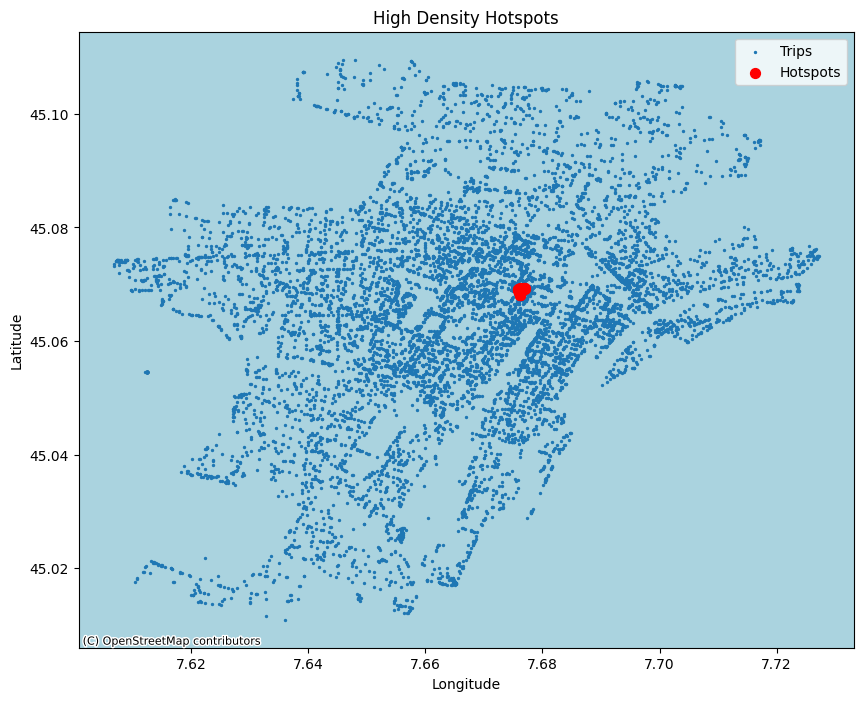

In [ ]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import contextily as ctx

def find_high_density_hotspots(trips_gdf, kde_bandwidth=0.1, num_hotspots=20):
    trip_coords = np.array([[p.x, p.y] for p in trips_gdf.geometry])  # (lon, lat)
    kde = gaussian_kde(trip_coords.T, bw_method=kde_bandwidth)  # Perform KDE
    hotspot_scores = kde(trip_coords.T)
    hotspot_indices = np.argsort(hotspot_scores)[-num_hotspots:]  # Top hotspots
    hotspots = trips_gdf.iloc[hotspot_indices]
    return hotspots
trips_gdf.to_crs(epsg=3857)
# Extract key locations for Voronoi Tessellation (e.g., city landmarks or trip hotspots)
#key_locations = find_high_density_hotspots(trips_gdf)
# Test with the first 1000 rows of trips_gdf
test_trips_gdf = trips_gdf.head(10000)
key_locations_test = find_high_density_hotspots(test_trips_gdf)

fig, ax = plt.subplots(figsize=(10, 10))
test_trips_gdf.geometry.x, test_trips_gdf.geometry.y, s=2, label="Trips".plot(
    color='blue',  
    markersize=3,
    ax=ax,
    legend=True,
    alpha=0.7,
    label=' Trips'
)

key_locations_test.geometry.x, key_locations_test.geometry.y, color='red', s=50, label="Hotspots".plot(
    color='maroon', 
    markersize=3,
    ax=ax,
    legend=True,
    alpha=0.7,
    label='Hotspots'
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("High Density Hotspots")
#plt.savefig("map_points_8_10_Sunday.png", dpi=300)
plt.legend()
plt.show()

# Visualize the hotspots
#fig, ax = plt.subplots(figsize=(10, 8))
#ax.scatter(test_trips_gdf.geometry.x, test_trips_gdf.geometry.y, s=2, label="Trips")
#ax.scatter(key_locations_test.geometry.x, key_locations_test.geometry.y, color='red', s=50, label="Hotspots")
#ax.set_title("High Density Hotspots")
#ax.set_xlabel("Longitude")
#ax.set_ylabel("Latitude")
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
#ax.legend()
#plt.show()

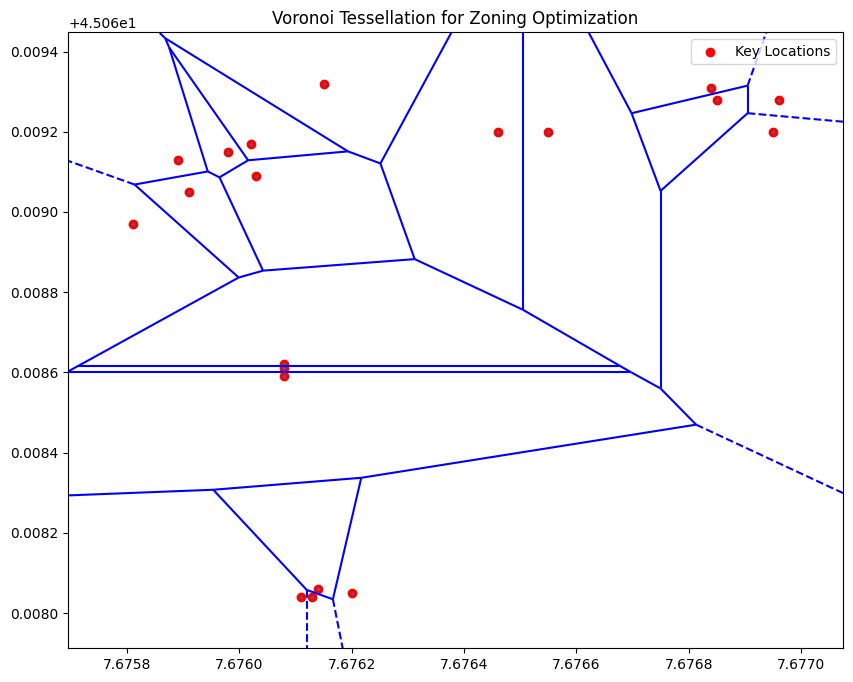

In [4]:

# Implement Voronoi Tessellation
from scipy.spatial import Voronoi, voronoi_plot_2d

# Extract coordinates of key locations for tessellation
key_coords = np.array([[point.x, point.y] for point in key_locations_test.geometry])

# Perform Voronoi Tessellation
vor = Voronoi(key_coords)

# Visualize Voronoi Tessellation
fig, ax = plt.subplots(figsize=(10, 8))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_width=1.5, point_size=2)
ax.scatter(key_coords[:, 0], key_coords[:, 1], color="red", label="Key Locations")
ax.set_title("Voronoi Tessellation for Zoning Optimization")
plt.legend()
plt.show()


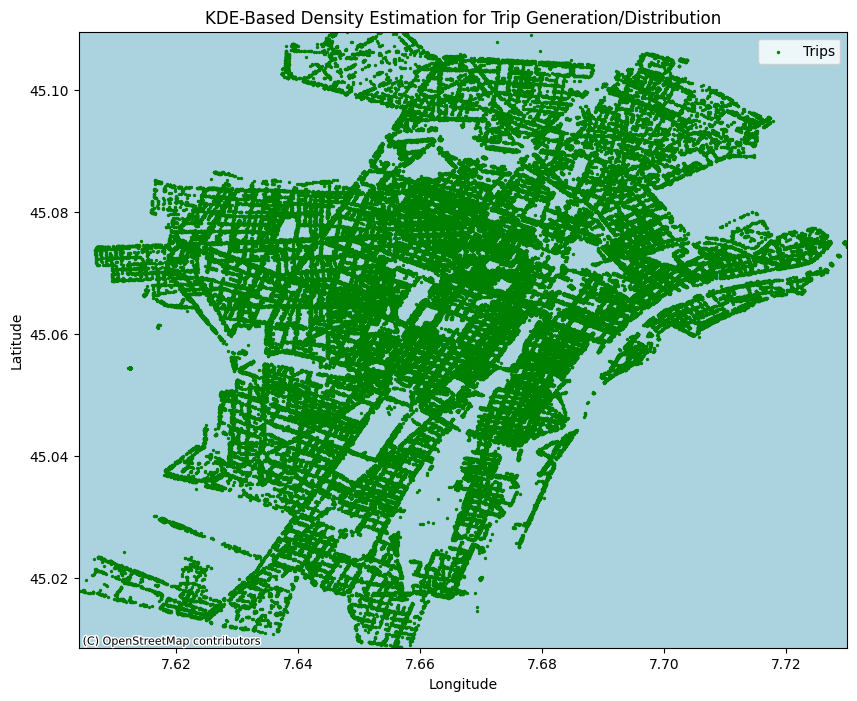

In [5]:

# Implement Kernel Density Estimation (KDE) for Continuous Density Estimation
# Extract coordinates for all trips
trip_coords = np.array([[point.x, point.y] for point in trips_gdf.geometry])

# Perform KDE
kde = gaussian_kde(trip_coords.T, bw_method=0.1)

# Define grid for KDE evaluation
x_min, y_min, x_max, y_max = trips_gdf.total_bounds
x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([x.ravel(), y.ravel()])
density = kde(positions).reshape(x.shape)

# Visualize KDE Density Map
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(np.rot90(density), extent=[x_min, x_max, y_min, y_max], cmap="coolwarm", alpha=0.8)
ax.scatter(trip_coords[:, 0], trip_coords[:, 1], color="green", s=2, label="Trips")
ax.set_title("KDE-Based Density Estimation for Trip Generation/Distribution")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.show()

# Saving key insights from Voronoi and KDE
#import ace_tools as tools; tools.display_dataframe_to_user(name="Key Locations and Voronoi Insights", dataframe=key_locations)



## Task 5
The idea is to compute the KDE for both dataset and then use Correlation and MSE to compare them

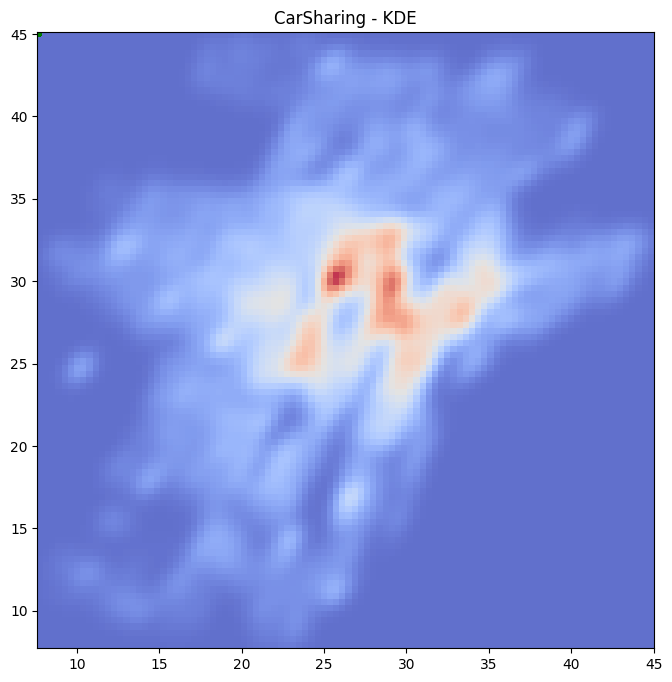

In [ ]:


# KDE and Quantitative Comparison
def compare_kde(carsharing_gdf, unipoltech_csv, bounds):
    # Load UnipolTech Trips
    unipoltech = pd.read_csv(unipoltech_csv)
    unipoltech["geometry_origin"] = gpd.points_from_xy(unipoltech["lon_start"], unipoltech["lat_start"])
    unipoltech["geometry_destination"] = gpd.points_from_xy(unipoltech["lon_stop"], unipoltech["lat_stop"])
    unipoltech_origins = gpd.GeoDataFrame(unipoltech, geometry="geometry_origin")
    unipoltech_destinations = gpd.GeoDataFrame(unipoltech, geometry="geometry_destination")

    # Prepare Coordinates
    carsharing_origins = np.array([[p.x, p.y] for p in carsharing_gdf.geometry])
    unipoltech_origins_coords = np.array([[p.x, p.y] for p in unipoltech_origins.geometry])

    # KDE and Plotting
    def estimate_kde(coords, title):
        kde = gaussian_kde(coords.T, bw_method=0.1)
        x, y = np.mgrid[bounds[0]:bounds[2]:100j, bounds[1]:bounds[3]:100j]
        density = kde(np.vstack([x.ravel(), y.ravel()])).reshape(x.shape)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(np.rot90(density), extent=bounds, cmap="coolwarm", alpha=0.8)
        ax.scatter(coords[:, 0], coords[:, 1], color="green", s=2, label="Trips")
        ax.set_title(title)
        plt.show()
        return density

    carsharing_density = estimate_kde(carsharing_origins, "CarSharing - KDE")
    unipoltech_density = estimate_kde(unipoltech_origins_coords, "UnipolTech - KDE")

    # Quantitative Comparison
    correlation = np.corrcoef(carsharing_density.ravel(), unipoltech_density.ravel())[0, 1]
    mse = mean_squared_error(carsharing_density.ravel(), unipoltech_density.ravel())
    print(f"Correlation: {correlation}, MSE: {mse}")

# Call the comparison function
compare_kde(trips_gdf, "data/Unipoldata/Trips_OD_TO.csv", trips_gdf.total_bounds)
